In [9]:
import numpy as np
from matplotlib.pyplot import *
import pandas as pd
from scipy.stats import circmean

# DANDI
import fsspec
import h5py
from fsspec.implementations.cached import CachingFileSystem
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient

# General overview of the dataset

The PhD thesis underlying this [DANDI-datset](https://dandiarchive.org/dandiset/000289?search=drosophila&page=1&sortOption=0&sortDir=-1&showDrafts=true&showEmpty=true&pos=3) can be found [here (Basnak, 2022)](https://dash.harvard.edu/server/api/core/bitstreams/2d87ca6c-ffb5-4b51-aabe-1216ae3416cb/content). The thesis focuses on how the fruit fly head direction circuit accounts for bump-attractor like dynamics coding for the location of the animal. If you're interested in the details of how undertainty is encoded in the head direction cells, check out the thesis.

In the set-up, the flies were head-fixed and positioned on a freely moving ball in a virtual reality surrounding while being recorded with two-photon Calcium imaging (panel B). A stimulus stripe of varying brightness (high, low, zero) was presented and rotated around the fly with the fly's own rotational velocity, mimicking the movement of the fly while allowing for a head-fixed set-up, as illustated in (panel C). The protocerebral bridge and the ellipsoid body of the fly are known to reflect its head-direction cells (panel A).
![image](./TaskSetup.png)

Here, we mostly want to show you how to load the data set. However, for analyzing new data it's important to learn about the dataset, data aquisition, imaging methods etc. So it is usually a good start to read the additional information like the PhD thesis. However, for this quick tutorial we will skip most of the details. Just note that if you were to start a project on this data, you should definitely do more research or even reach out to the dataset author.

# Load the behavioral data

In [2]:
from dandi.dandiapi import DandiAPIClient

# get dataset ID, filename of a session of interest from https://dandiarchive.org/
dandiset_id = '000289'
file_path = "sub-1/sub-1_ses-20201019T000000_behavior+ophys.nwb"#.nwb" # file size ~67GB

# This is how the DANDI API can be used to load data, it is always the same for all datasets
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

# Create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
# No need to understand in depth, this is just how you load nwb datasets
fs = fsspec.filesystem("http")
file_system = fs.open(s3_url, "rb")
file = h5py.File(file_system, mode="r")
# Open the file with NWBHDF5IO
io = NWBHDF5IO(file=file, load_namespaces=True)

nwb = io.read()

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.5.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


If we print the loaded file, we can see which information is provided. Klick on the different subsections to get an intuition on what is saved where. For example, most nwb files contain the behavioral information in the **trials** subsection.

In [3]:
# print the file to get a general, browsable overview
nwb

Data type,int16
Shape,"(11020, 12, 256, 128)"
Array size,8.07 GiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(11020,)"
Array size,86.09 KiB
Chunk shape,None


You can load the trial structure information into a dataframe in the following manner. It tells you when a trial starts, when it ends and the amount of contrast in each trial.

In [4]:
trials = nwb.trials
df_trials = trials.to_dataframe() # generate a dataframe out of nwb subsection
df_trials

,start_time,stop_time,cue_contrast
id,,,
0,0.00,195.04,2.0
1,195.04,394.98,1.0
2,394.98,594.92,3.0
3,594.92,794.98,1.0
4,794.98,995.02,2.0
5,995.02,1199.98,3.0


### Load the animal's behavior

We now want to access what the animal was doing during the trials. After looking into the nwb file and browsing a bit, we find that there is a lot of information in the "processing" sub-channel. Can you find how to get the data?

**Tip:** Once you have something in the shape of an HDF5 file you can convert it to an array using the np.array() function.

In [5]:
# get the time stamp of each movement
turning_time = np.array(nwb.processing['behavior'].data_interfaces['Position'].spatial_series['SpatialSeries'].timestamps)
# get the turning direction in radians (0 is centered at the stimulus)
turning_direction = np.array(nwb.processing['behavior'].data_interfaces['Position'].spatial_series['SpatialSeries'].data)
# turn tunring direction to [-pi, pi] while maintaing 0 as facing the stimulus location
turning_direction[turning_direction>np.pi] = turning_direction[turning_direction>np.pi]-2*np.pi

# turn into dataframe
dict_behav = {'time': turning_time, 'behavior': turning_direction}
df_behav = pd.DataFrame(dict_behav)
# convert time into minutes for ease of use
df_behav['time_min'] = (df_behav.time)/60
# add the stimulus (from the previous step) to the behavioral dataframe
df_behav['stimulus'] = np.zeros((len(df_behav)))
for trial in df_trials.index: # for each trial
    # if the behavior happens during the trial's time, add the stimulus to the dataframe
    df_behav.loc[np.where((df_behav.time >= df_trials.start_time[trial]) &\
                           (df_behav.time <= df_trials.stop_time[trial]))[0], 'stimulus'] = df_trials.cue_contrast[trial]
df_behav.head()

,time,behavior,time_min,stimulus
0,0.00,0.776721,0.000000,2.0
1,0.10,1.174820,0.001667,2.0
2,0.22,1.434338,0.003667,2.0
3,0.32,1.816281,0.005333,2.0
4,0.44,2.194129,0.007333,2.0


Let's plot the animals heading direction through a full session. The top bars indicate the stimulus strength (the more blue, the stronger the stimulus). 

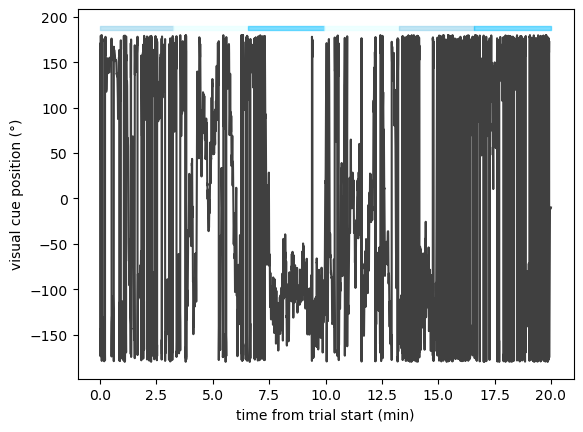

In [6]:
plot(df_behav.time_min, np.rad2deg(df_behav.behavior), color='k', alpha=0.75)
xlabel('time from trial start (min)')
ylabel('visual cue position (°)')

# fill-in the stimulus strength
stim_colors = [np.nan, 'lightcyan', 'skyblue', 'deepskyblue']
for i in df_trials.index:
    fill_between([df_trials.start_time[i]/60, df_trials.stop_time[i]/60], [185, 185], [190, 190],\
                 alpha=0.5, color=stim_colors[int(df_trials.cue_contrast[i])])

Wow, that's quite noisy. No worries, we will take care of that in a bit!

# Neural data

Let's load the neural data. Again, check in the browsable nwb file ($\uparrow$) to find how to access the data. 

**Tip:** Start at processing.ophys and see if you can find some neural data.

In [7]:
# get the neural firing (tip: there are 41 ROIs in this session, half for the left PB, half for the right)
neural_direction = np.array(nwb.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'].data)
change = int(neural_direction.shape[1]/2)
# get the time stamps
neural_timing = np.array(nwb.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'].timestamps)

# turn into neural dataframe
dict_neural = {'time': neural_timing, 'neural': [neural_direction[i] for i in range(len(neural_direction))]}
df_neural = pd.DataFrame(dict_neural)
df_neural['time_min'] = (df_neural.time - np.min(df_neural.time))/60

df_neural.head()

,time,neural,time_min
0,0.00,"[0.04328892373488647, -0.10167671886986798, -0...",0.000000
1,0.10,"[-0.1433636927817354, -0.04385471678418592, -0...",0.001667
2,0.22,"[-0.02687941519679163, -0.1432998655031763, 0....",0.003667
3,0.32,"[-0.11051377147095699, 0.08152786792941763, -0...",0.005333
4,0.44,"[0.013165523949067445, -0.0013355395724889813,...",0.007333


### Smooth the neural and behavioral data

For a better overview of the dynamics, we want to smooth the time axis. Instead of having 120ms steps, we want to have 5s timesteps and apply a smoothing window of 10s. These times might be quite large but we first want to gain a general overview.

In [10]:
# initialize
smoothed_time = []
smoothed_behav = []
smoothed_neural = []
smoothed_stimulus = []

w_step = 5 / 60 # 5s steps converted to minutes
w_width = 10 / 60 # 10s window converted to minutes
# for each time step, get the data in question and average it in the specified time window
for steps in np.arange(0, df_neural.time_min.max() ,w_step):
    df_b = df_behav.loc[(df_behav.time_min > steps) & (df_behav.time_min <= steps+w_width)]
    df_n = df_neural.loc[(df_neural.time_min > steps) & (df_neural.time_min <= steps+w_width)]

    # for each time step save the averaged data to a list
    smoothed_time.append(np.mean(df_b.time_min))
    smoothed_behav.append(circmean(df_b.behavior, low=-np.pi, high=np.pi))
    smoothed_neural.append(np.mean(df_n.neural, axis=0))
    smoothed_stimulus.append(np.mean(df_b.stimulus))

# generate a smoothed dataframe
dict_smoothed = {'time_min': smoothed_time, 'behavior': smoothed_behav, 'neural': smoothed_neural, 'stimulus': smoothed_stimulus}
df_smoothed = pd.DataFrame(dict_smoothed)

### Plot the neural firing rates and the heading direction

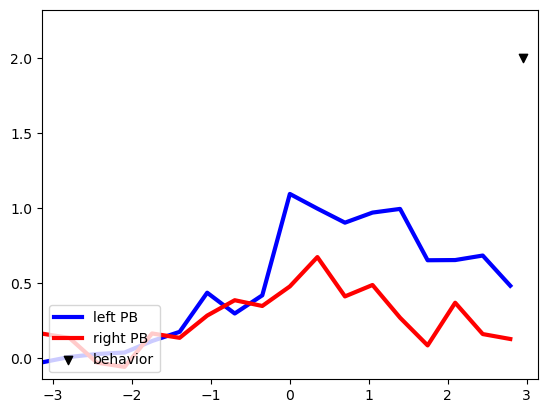

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML


# split into left and right PB (they are mirror copies of each other)
leftPB = np.array([df_smoothed.neural[i][:change] for i in df_smoothed.index])
rightPB = np.array([df_smoothed.neural[i][change+1:] for i in df_smoothed.index])

# initializing a figure
fig = figure() 
# marking the x-axis and y-axis limits
ax = axes(xlim =(-np.pi, np.pi), 
                ylim =(np.min([leftPB, rightPB]), np.max([leftPB, rightPB]))) 

# initializing a line, scatter variable to update
line, = ax.plot([], [], lw = 3, color='blue', label='left PB') 
line2, = ax.plot([], [], lw = 3, color='red', label='right PB') 
scat = ax.scatter([],  [], marker='v', color='k', label='behavior')
ax.legend(loc=3)

def update(frame):
    """A function called on every frame:
    Draw a 
                lineplot of the left PB activity 
                lineplot of the right PB activity 
                scatterplot of the heading direction as a tick mark"""
    x = np.linspace(-np.pi, np.pi, len(leftPB[frame]), endpoint=False)
    line.set_data(x, leftPB[frame,:])
    line2.set_data(x, rightPB[frame,:])
    scat.set_offsets([df_smoothed.behavior[frame], 2.])
    return line, line2, scat

# animate the activity and behavior for visualization
ani = FuncAnimation(fig, update,
                     frames = len(leftPB), interval = 100)#
HTML(ani.to_html5_video())
 




## Oh, no! There seems to be an offset between where the neurons are pointing and where the bumps are pointing.

The problem is that th fly PB works in world-centered coordinates and while the experiment tries to define a world-centered system through the stimulus location, it does not mean that the neuron's accept the stimulus location as its "north". One way to fix this alignment issue is by using linear models to align the neural space and the behavioral space. You will learn about this in the next couple of das, so stay tuned!

**Outlook:**
This would also help us in establishing how well the neural activity tracks head direction cells systematically across sessions. For example we could ask how *uncertainty* affects the bump dynamics based on if the displayed stimulus is strong, weak or off (as done in the PhD thesis). And other fun analyses to understand how bump attractor dynamics underlie the fly head direction system.